# 응용 : 안면 인식 파이프라인

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG 특징

1. 선택적으로 이미지를 사전에 정규화한다. 이로써 빛의 변화에 의존하지 않는 특징을 얻게 된다.
2. 수평적, 수직적 밝기 경도에 민감한 두 필터로 이미지를 휘감는다. 이 필터가 모서리의 윤곽, 질감 정보를 포착한다.
3. 이미지를 사전 정의한 크기의 셀로 나누고, 각 셀 내의 경사 방향의 히스토그램을 계산한다.
4. 이웃하는 셀의 블록과 비교해서 각 셀의 히스토그램을 정규화한다. 이로써 전체 이미지에 대한 빛의 영향이 더 억제된다.
5. 각 셀의 정보로부터 1차원 특징 벡터를 구성한다.

In [2]:
from skimage import data, color, feature
import skimage.data

Text(0.5, 1.0, 'visualization of HOG features')

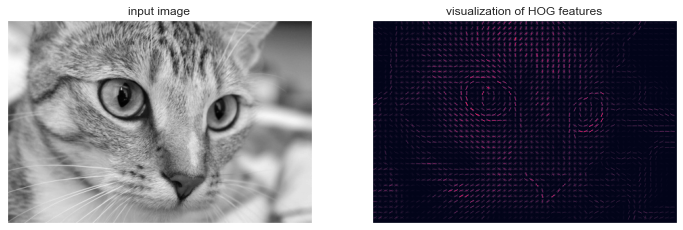

In [3]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize = True)

fig, ax = plt.subplots(1, 2, figsize = (12, 6), subplot_kw = dict(xticks = [], yticks = []))

ax[0].imshow(image, cmap = 'gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features')

## 실제 HOG : 간단한 안면 인식기

###### 안면 인식 알고리즘 단계
1. '긍정' 훈련 표본을 구성하기 위해 얼굴 이미지 썸네일을 구한다.
2. '부정' 훈련 표본을 구성하기 위해 얼굴이 아닌 이미지 썸네일 구한다.
3. 이 훈련 표본으로부터 SVM 분류기를 훈련시킨다.
4. 이 표본에 선형 SVM 분류기를 훈련시킨다.
5. '알려지지 않은' 이미지에 대해서는 이미지에 슬라이딩 윈도우를 전달하고 그 모델을 사용해 해당 윈도우가 얼굴을 포함하고 있는지 아닌지 평가한다.
6. 얼굴 인식이 겹치면 하나의 윈도우에 결합한다.

In [4]:
# 1. 긍정 훈련 표본을 구한다

from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [5]:
# 2. 부정 훈련 표본을 구한다

from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [6]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale = 1.0, patch_size = positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size = extracted_patch_size, max_patches = N, random_state = 0)
    patches = extractor.transform(img[np.newaxis])
    
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    
    return patches

In [7]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

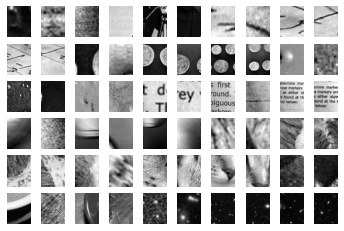

In [8]:
fig, ax = plt.subplots(6, 10)

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap = 'gray')
    axi.axis('off')

In [9]:
# 3. 집합을 결합하고 HOG 특징을 추출한다

from itertools import chain

X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape

(43233, 1215)

In [10]:
# 4. SVM을 훈련시킨다

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94726495, 0.97131953, 0.97189777, 0.97478603, 0.97455471])

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C' : [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\sv

0.9887122973043431

In [12]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

(-0.5, 139.5, 159.5, -0.5)

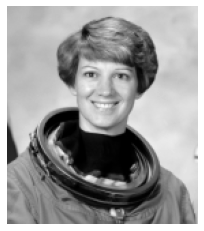

In [13]:
# 5. 새 이미지에서 얼굴을 찾는다

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap = 'gray')
plt.axis('off')

In [14]:
def sliding_window(img, patch_size = positive_patches[0].shape, istep = 2, jstep = 2, scale = 1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j +Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [15]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [16]:
# 6. HOG 특징을 추출한 조각을 사용하여, 각 조각에 얼굴이 포함되어 있는지 평가

labels = model.predict(patches_hog)
labels.sum()

50.0

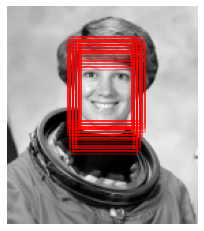

In [17]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap = 'gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor = 'red', alpha = 0.3, lw = 2, facecolor = 'none'))

## 주의사항 및 개선사항

### 훈련 집합, 특히 부정 특징에 대한 훈련 집합이 그다지 완전하지 않다.

### 현재 파이프라인은 한 척도로만 검색한다.

### 탐지된 이미지 조각이 겹친 경우, 이를 결합해야 한다.

### 파이프라인이 간결해야 한다.

### 딥 러닝 같은 최신 기술을 고려해야 한다.